# Guide on how to use the backtester

In [30]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [ ]:
from datamodel import OrderDepth, UserId, TradingState, Order, ConversionObservation, Observation

import numpy as np

CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

CAMILLA = "Camilla"
PABLO = "Pablo"
SUBMISSION = "SUBMISSION"


class OliviaCroissant:
    def __init__(self):
        # CONSTANT
        self.position_limit = {CROISSANTS: 250, DJEMBES: 60, JAMS: 350, PICNIC_BASKET1: 60, PICNIC_BASKET2: 100}

        # we either want to be limit long or limit short.
        # limit long: c=360,j=-350,d=-60,pb1=60,pb2=100
        # net: +1010c, +30j, +0d
        # delta exposure of 30j

        # limit short: c=-360,j=350,d=60,pb1=-60,pb2=-100
        # net: -1010c, -30j, +0d
        # delta exposure of 30j

        # RUNTIME
        self.last_buysignal_timestamp = -9999999
        self.last_sellsignal_timestamp = -9999999
        self.last_olivia_buyprice = -1
        self.last_olivia_sellprice = -1

        # CONFIG
        self.spread_tol = {CROISSANTS: 4, DJEMBES: 4, JAMS: 4, PICNIC_BASKET1: 11, PICNIC_BASKET2: 11}
        self.signal_timeout = 2000

        pass

    def _get_mid_price(self, state: TradingState, product: str) -> float:
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        return (max(buy_orders) + max(sell_orders)) / 2

    def _execute_buy(self, state: TradingState, product: str, desired_pos: int):
        orders = []
        midprice = self._get_mid_price(state, product)
        position = state.position.get(product, 0)

        for price, qty in sorted(state.order_depths[product].sell_orders.items()):
            qty_executed = min(abs(qty), desired_pos - position)

            if qty_executed > 0 and price <= midprice + self.spread_tol[product]:
                orders.append(Order(product, price, qty_executed))
                position += qty_executed

        # limit order
        qty_remaining = desired_pos - position
        if qty_remaining != 0:
            orders.append(Order(product, int(np.floor(midprice)), qty_remaining))

        return orders

    def _execute_sell(self, state: TradingState, product: str, desired_pos: int):
        orders = []
        midprice = self._get_mid_price(state, product)
        position = state.position.get(product, 0)

        for price, qty in sorted(state.order_depths[product].buy_orders.items(), reverse=True):
            qty_executed = min(qty, abs(desired_pos - position))

            if qty_executed > 0 and price >= midprice - self.spread_tol[product]:
                orders.append(Order(product, price, -qty_executed))
                position -= qty_executed

        # limit order
        qty_remaining = abs(desired_pos - position)
        if qty_remaining != 0:
            orders.append(Order(product, int(np.ceil(midprice)), -qty_remaining))

        return orders

    def run(self, state: TradingState):
        result = {}
        if CROISSANTS in state.order_depths:
            market_trades = state.market_trades.get(CROISSANTS, [])

            olivia_buy_vol = 0
            olivia_sell_vol = 0
            for trade in market_trades:
                if trade.buyer == "Olivia" and trade.seller != "Olivia":
                    olivia_buy_vol += trade.quantity
                elif trade.seller == "Olivia" and trade.buyer != "Olivia":
                    olivia_sell_vol += trade.quantity

            if olivia_buy_vol > olivia_sell_vol:
                self.last_buysignal_timestamp = state.timestamp
                self.last_olivia_buyprice = trade.price
            elif olivia_buy_vol < olivia_sell_vol:
                self.last_sellsignal_timestamp = state.timestamp
                self.last_olivia_sellprice = trade.price

            time_since_last_buysignal = state.timestamp - self.last_buysignal_timestamp
            time_since_last_sellsignal = state.timestamp - self.last_sellsignal_timestamp

            if time_since_last_buysignal < time_since_last_sellsignal and time_since_last_buysignal < self.signal_timeout:
                # limit long croissants
                result[CROISSANTS] = self._execute_buy(state, CROISSANTS, 250)
                result[JAMS] = self._execute_sell(state, JAMS, -350)
                result[DJEMBES] = self._execute_sell(state, DJEMBES, -60)
                result[PICNIC_BASKET1] = self._execute_buy(state, PICNIC_BASKET1, 60)
                result[PICNIC_BASKET2] = self._execute_buy(state, PICNIC_BASKET2, 100)

            elif time_since_last_sellsignal < time_since_last_buysignal and time_since_last_sellsignal < self.signal_timeout:
                # limit short croissants
                result[CROISSANTS] = self._execute_sell(state, CROISSANTS, -250)
                result[JAMS] = self._execute_buy(state, JAMS, 350)
                result[DJEMBES] = self._execute_buy(state, DJEMBES, 60)
                result[PICNIC_BASKET1] = self._execute_sell(state, PICNIC_BASKET1, -60)
                result[PICNIC_BASKET2] = self._execute_sell(state, PICNIC_BASKET2, -100)

        return result, 0, ""

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [32]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [33]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    # "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    "CROISSANTS": 250,
    "DJEMBES": 60,
    "JAMS": 350,
    # "KELP": 50,
    "PICNIC_BASKET1": 60,
    "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
    # "MAGNIFICENT_MACARONS": 75,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object

trader = OliviaCroissant()

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_5_all3days, trades_round_5_all3days, observations_round_5_all3days)
bt.run()
bt.pnl()

{'spreadcrossing': {'CROISSANTS': 60998.0,
  'DJEMBES': -12076.0,
  'JAMS': 40921.0,
  'PICNIC_BASKET1': 38350.0,
  'PICNIC_BASKET2': 47794.0,
  'total': 175987.0},
 'midpoint': {'CROISSANTS': 62538.5,
  'DJEMBES': -11624.0,
  'JAMS': 44069.5,
  'PICNIC_BASKET1': 41459.0,
  'PICNIC_BASKET2': 50673.5,
  'total': 187116.5}}

Available metrics: ['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps', 'position']
Midpoint sharpe: 0.21823439979793605
Spreadcrossing sharpe: 0.20512467159534345


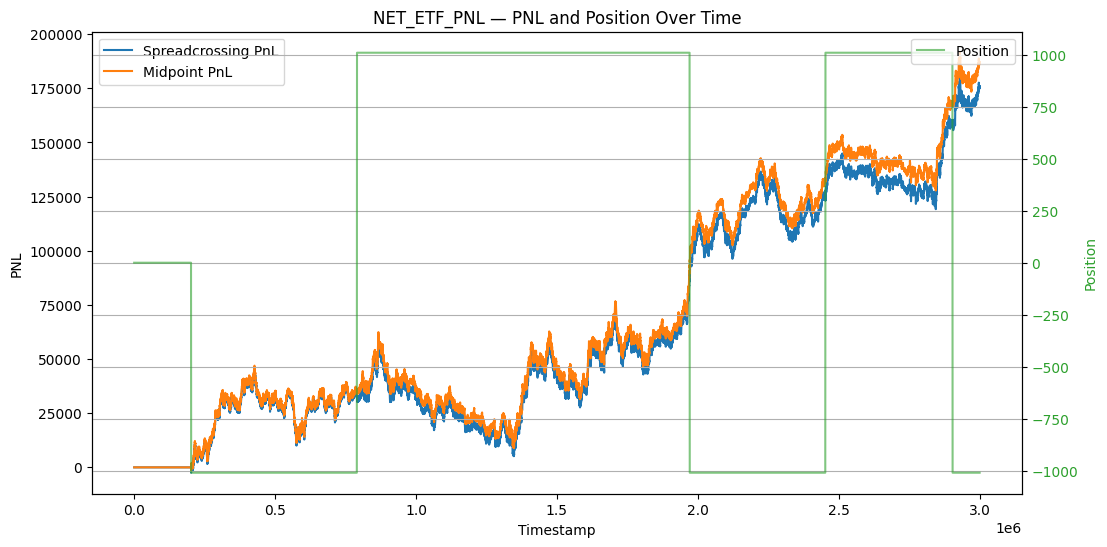

In [34]:
import matplotlib.pyplot as plt

product = "NET_ETF_PNL"
metrics = bt.calculate_metrics(product)

print(f"Available metrics: {list(metrics.keys())}")

print(f"Midpoint sharpe: {metrics['midpoint_sharpe']}")
print(f"Spreadcrossing sharpe: {metrics['spreadcrossing_sharpe']}")
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: PnL
ax1.plot(metrics['timestamp'], metrics['spreadcrossing_pnl'], label='Spreadcrossing PnL', color='tab:blue')
ax1.plot(metrics['timestamp'], metrics['midpoint_pnl'], label='Midpoint PnL', color='tab:orange')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("PNL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Second y-axis: Position
ax2 = ax1.twinx()
ax2.plot(metrics['timestamp'], metrics['position'], label='Position', color='tab:green', alpha=0.6)
ax2.set_ylabel("Position", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"{product} — PNL and Position Over Time")
plt.grid(True)
plt.show()




In [39]:
th = trades_round_5_day_4.copy()


th = th[th["symbol"] == PICNIC_BASKET2]

np.sum(th["quantity"])


def calc_spread_stats(market_data: pd.DataFrame, product: str):
    md = market_data.copy()
    md = md[md["product"] == product]

    spread1 = md["ask_price_1"] - md["bid_price_1"]
    spread2 = md["ask_price_2"] - md["bid_price_2"]
    spread3 = md["ask_price_3"] - md["bid_price_3"]

    spread1.dropna(inplace=True)
    spread2.dropna(inplace=True)
    spread3.dropna(inplace=True)

    return np.mean(spread1), np.std(spread1), np.mean(spread2), np.std(spread2), np.mean(spread3), np.std(spread3)


print(f"{CROISSANTS}: {calc_spread_stats(market_data_round_5_day_4, CROISSANTS)}")
print(f"{DJEMBES}: {calc_spread_stats(market_data_round_5_day_4, DJEMBES)}")
print(f"{JAMS}: {calc_spread_stats(market_data_round_5_day_4, JAMS)}")
print(f"{PICNIC_BASKET1}: {calc_spread_stats(market_data_round_5_day_4, PICNIC_BASKET1)}")
print(f"{PICNIC_BASKET2}: {calc_spread_stats(market_data_round_5_day_4, PICNIC_BASKET2)}")



md = market_data_round_5_day_4.copy()
md = md[md["product"] == PICNIC_BASKET1]
np.mean(md['ask_volume_1'])

CROISSANTS: (1.2093, 0.40680893549675134, nan, nan, nan, nan)
DJEMBES: (1.2673, 0.44255023443672464, nan, nan, nan, nan)
JAMS: (1.615, 0.4865953144040744, 3.0, 0.0, nan, nan)
PICNIC_BASKET1: (9.176, 1.933810745652221, 11.544643828167482, 0.903044437421755, 12.896383866481225, 0.3047619241201158)
PICNIC_BASKET2: (5.2088, 1.0970882188775886, 6.952102182011708, 0.36888653163318197, nan, nan)


8.0383

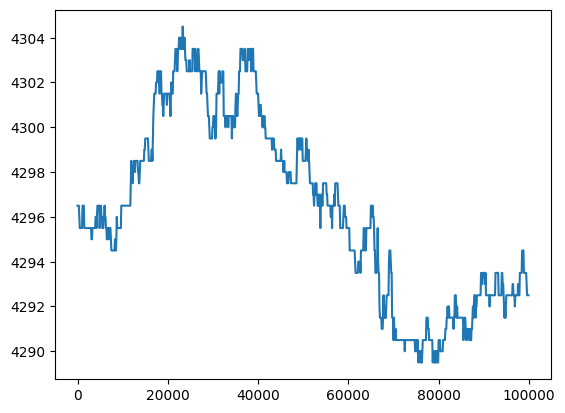

In [40]:
# th = trades_round_5_all3days.copy()

# party = "Peter"
# th = th[(th['buyer'] == party) ^ (th['seller'] == party)]

# # np.unique(th['quantity'])
# d = th['timestamp'].diff().dropna()
# np.mean(d), np.std(d)


# # md = market_data_round_5_all3days.copy()
# # md = md[md['product'] == KELP]


# # spread = md['ask_price_1'] - md['bid_price_1']


md = market_data_round_5_day_4.copy()
md = md[md['product'] == CROISSANTS]

md = md[(md['timestamp'] < 1e5)]

plt.plot(md['timestamp'], md['mid_price'])